## Introduction

### Explainability in Neural Networks

Neural networks, and in particular deep neural networks, suffer from the inability for humans to readily understand how the network arrived at a specific answer - in the case of classification, what combination of features, and in what proportions, did the network use to determine the class it assigns to any given test sample. This lack of transparency is a severe hinderance to the adoption of neural networks in many domains where such explainability is required, for example domains including medical diagnostics, criminal justice, risk management, and loan approvals. 

The objective of this notebook is to explore the usefulness of several explainability tools in context of the evaluation of chest x-rays datasets that have been created to attempt to identify patients with Covid-19. The specific tools to be examined are [Local Interpretable Model-Agnostic Explanations (LIME)] (https://arxiv.org/pdf/1602.04938v1.pdf), [Gradcam](https://arxiv.org/pdf/1610.02391.pdf), and [SHAP](https://arxiv.org/pdf/1705.07874.pdf).

### Acknowledgements

SHAP repo https://github.com/slundberg/shap

The starting code of this repository is based on the Covid-19 Chest X-Ray Model [repository](https://github.com/aildnont/covid-cxr), which provides the core code platform used for the evaluation. The SHAP implementation is based on the following [repository]( https://github.com/slundberg/shap).

### Platform Architecture

#### Hardware

The experiments were run on a Core-i7 desktop with an nVidia GTX 1050 Ti GPU running under Ubuntu linux 20.04 LTS.

#### Software

We leveraged the frameworks provided and modified them to suit our goal of better understanding how the network made its predictions. The framework was very well parameterized, allowing setting up runs based on yml files located in the home directory. The Readme .md files in the original repositories provide a good reference on the parameter setting.

### Our Experiments

Our experiments focused on understanding what areas of the x-rays the model found significant in its determination of whether or not the specific x-ray indicated the presence of Covid-19. The premise of the original work done by the Covid-19 Chest X-Ray Model group is that changes in the lungs of Covid-19 patients could be used to identify the presence of the disease, and by using the explainability techniques we would be able to determine what areas of the x-ray the neural network considered most important in its prediction. If the model is operating in accordance with the premise of making diagnoses based on lung condition, this should be reflected in the explainability results. If other areas of the x-ray were shown to have effected the prediction, this would cast doubt on either the authors' fundamental premise, the specific prediction by the model for an individual x-ray, or both.


### The Datasets

Three datasets were used in the experiments:

1. [COVID-19 image data collection](https://github.com/ieee8023/covid-chestxray-dataset).
2. [Figure 1 COVID-19 Chest X-ray Dataset Initiative](https://github.com/agchung/Figure1-COVID-chestxray-dataset).
3. [RSNA Pneumonia Detection Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data).

The first two datasets represent collections of x-rays taken from patients either having, or are suspected of having, Covid-19. The third dataset consists of x-rays taken from patients with pneumonia and represent x-rays that differ from those of healthy patients adn therefore represent lung abnormalities, but are not representative of Covid-19 patients.

Note that due to the prepondernce of non-Covid-19 x-rays in the dataset, during the model training the python imblearn module was used to attempt to correct for the imbalance.

### ResNet50v2 vs. DNCC_resnet

In terms of classifiers, the original researchers used an instrumented version of the resnet architecture. We decided that since we were going to use the model we trained for the LIME and GRADCAM with the SHAP code as well, we would instead use the standard ResNet50v2 classifier in an attempt to maximize compatibility.


In [1]:
# import required common modules and utilites

import pandas as pd
import yaml
import os
import datetime
import random
import dill
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.summary as tf_summary
from imblearn.over_sampling import RandomOverSampler
from math import ceil
from tensorflow.keras.metrics import BinaryAccuracy, CategoricalAccuracy, Precision, Recall, AUC
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorboard.plugins.hparams import api as hp
import sys
sys.path.append("/home/getech/Documents/covid-cxr") # Add root dir to path variable
os.chdir("/home/getech/Documents/covid-cxr") # Set pwd to root dir to import files from src module.
from src.models.models import *
from src.visualization.visualize import *
from src.custom.metrics import F1Score
from src.data.preprocess import remove_text

In [ ]:
# create train, validation, and test datasets
import src.data.preprocess

src.data.preprocess.preprocess()

_______________________________________________
conv4_block3_out (Add)          (None, 14, 14, 1024) 0           conv4_block2_out[0][0]           
                                                                 conv4_block3_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_preact_bn (BatchNo (None, 14, 14, 1024) 4096        conv4_block3_out[0][0]           
__________________________________________________________________________________________________
conv4_block4_preact_relu (Activ (None, 14, 14, 1024) 0           conv4_block4_preact_bn[0][0]     
__________________________________________________________________________________________________
conv4_block4_1_conv (Conv2D)    (None, 14, 14, 256)  262144      conv4_block4_preact_relu[0][0]   
__________________________________________________________________________________________________
conv4_block4_1_bn (BatchNormali (None, 14, 14, 256)  1024    

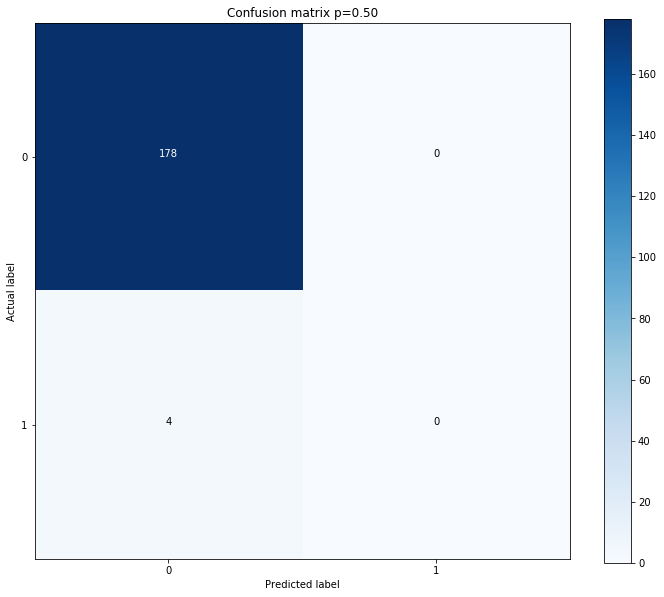

In [2]:
# Begin experiment by training model, using resnetv2 classifier for maximum compatibility with later shap evaluation:

import src.train

# configure model to use class_weights and perform training run:
cfg = yaml.full_load(open(os.getcwd() + "/config_class_weights.yml", 'r'))
src.train.train_experiment(cfg=cfg, experiment=cfg['TRAIN']['EXPERIMENT_TYPE'], save_weights=True, write_logs=True)

onv4_block4_preact_bn[0][0]     
__________________________________________________________________________________________________
conv4_block4_1_conv (Conv2D)    (None, 14, 14, 256)  262144      conv4_block4_preact_relu[0][0]   
__________________________________________________________________________________________________
conv4_block4_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block4_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_1_relu (Activation (None, 14, 14, 256)  0           conv4_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_2_pad (ZeroPadding (None, 16, 16, 256)  0           conv4_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block4_2_conv (Conv2D)    (None, 14, 14, 256)  589824      conv4_block

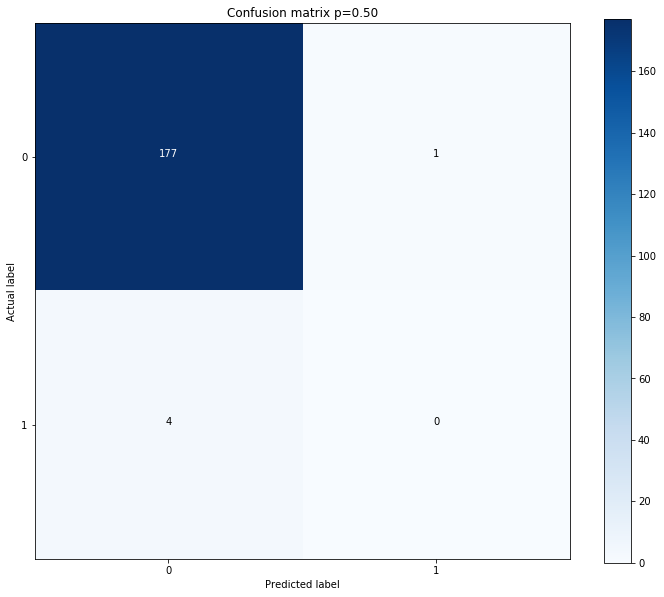

In [4]:
# perform comparison with random_oversample:
import src.train

cfg = yaml.full_load(open(os.getcwd() + "/config_random_oversample.yml", 'r'))
src.train.train_experiment(cfg=cfg, experiment=cfg['TRAIN']['EXPERIMENT_TYPE'], save_weights=True, write_logs=True)

# LIME tests #

### Test 1 - ResNet50v2 with class weights ###

Found 182 non-validated image filenames belonging to 2 classes.

Intercept 0.030115368756337902
Prediction_local [-0.01992512]
Right: 0.0016968384
Intercept 0.9698846386637172
Prediction_local [1.01992511]
Right: 0.9983032
Explanation time = 25.174559 seconds


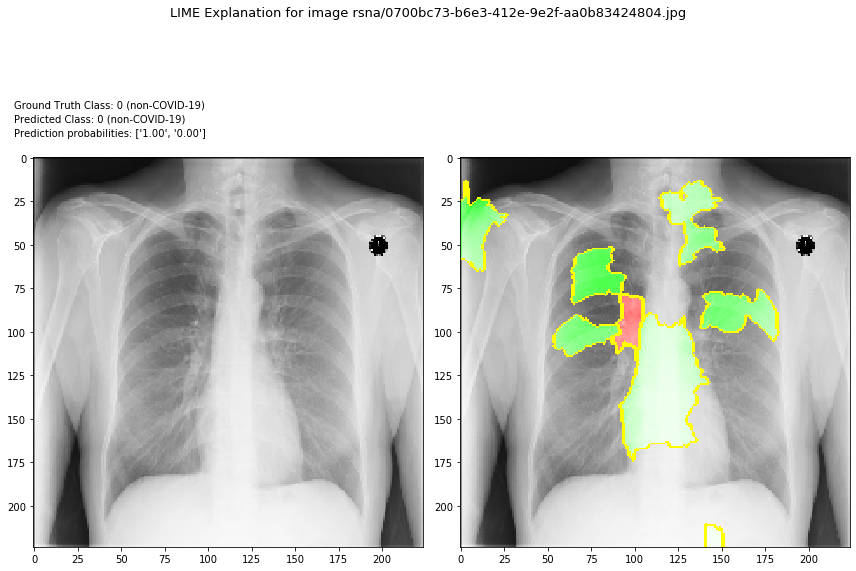

In [4]:
# create images using the trained models
import src.interpretability.lime_explain

lime_dict = src.interpretability.lime_explain.setup_lime('_class_weights')
# choose a negative covid xray
i = 0                                    
src.interpretability.lime_explain.explain_xray(lime_dict, i, save_exp=True)


Intercept 0.7296641482773111
Prediction_local [-0.28149544]
Right: 0.008043092
Intercept 0.2703358496147872
Prediction_local [1.28149544]
Right: 0.99195695
Explanation time = 11.58137 seconds


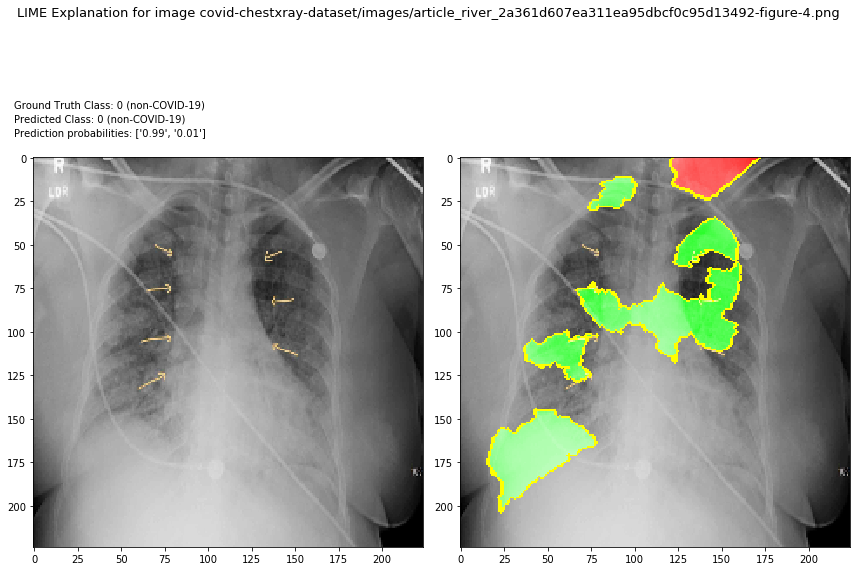

In [6]:
i = 22                                  
src.interpretability.lime_explain.explain_xray(lime_dict, i, save_exp=True)

### Test 2 - ResNet50v2 with random oversample ###

Found 182 non-validated image filenames belonging to 2 classes.

Intercept 0.872758271086689
Prediction_local [-0.00656215]
Right: 0.076208696
Intercept 0.12724173594651983
Prediction_local [1.00656214]
Right: 0.9237913
Explanation time = 13.467276 seconds


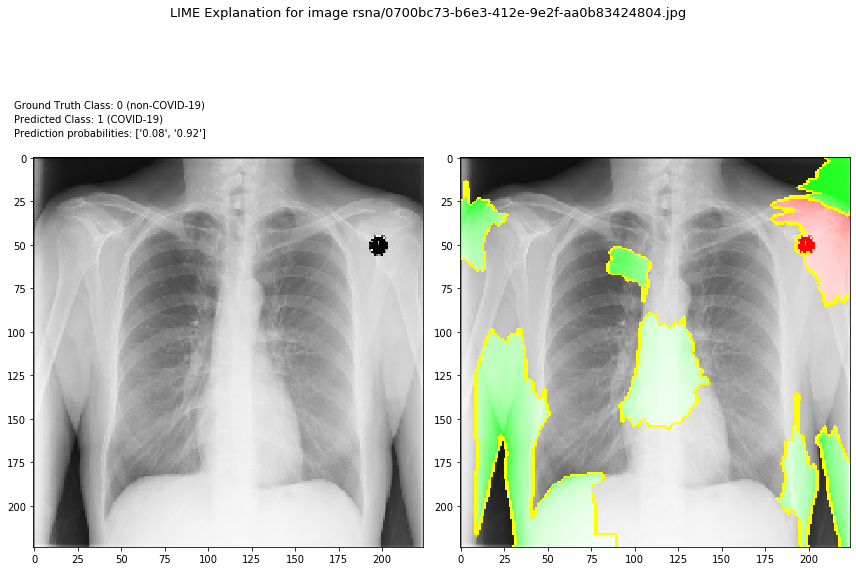

In [7]:
# compare random_oversample
lime_dict = src.interpretability.lime_explain.setup_lime('_random_oversample')
# choose a negative covid xray
i = 0                                    
src.interpretability.lime_explain.explain_xray(lime_dict, i, save_exp=True)


Intercept 0.034995539949007406
Prediction_local [-0.00816354]
Right: 0.0018502139
Intercept 0.965004440216007
Prediction_local [1.00816355]
Right: 0.9981499
Explanation time = 8.860754 seconds


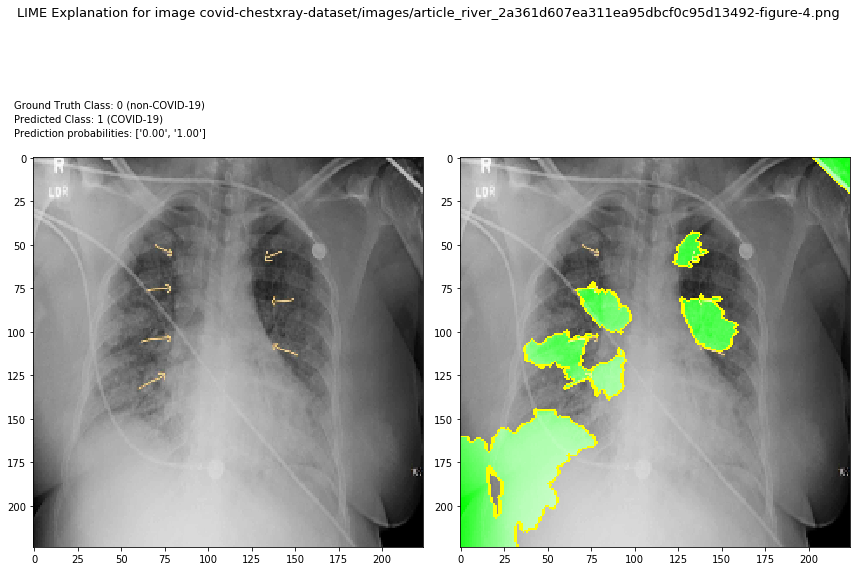

In [8]:
i = 22                                  
src.interpretability.lime_explain.explain_xray(lime_dict, i, save_exp=True)

# GRADCAM tests #

### Test 2 - ResNet50v2 with class weights ###

 256)  262144      conv4_block2_preact_relu[0][0]   
__________________________________________________________________________________________________
conv4_block2_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_1_relu (Activation (None, 14, 14, 256)  0           conv4_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_2_pad (ZeroPadding (None, 16, 16, 256)  0           conv4_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_2_conv (Conv2D)    (None, 14, 14, 256)  589824      conv4_block2_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_block2_2_bn (BatchNormali (None, 14, 14, 256)  102

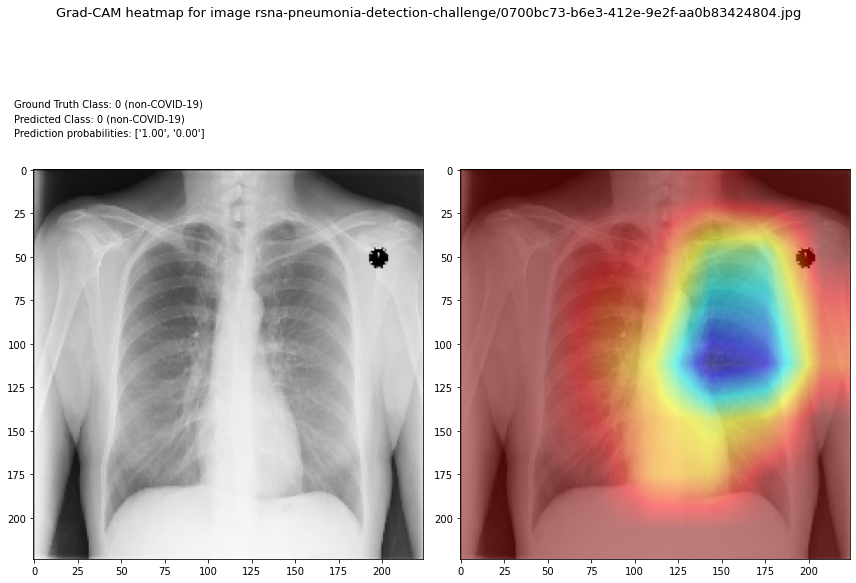

In [5]:
import src.interpretability.gradcam

setup_dict = src.interpretability.gradcam.setup_gradcam('_class_weights')
heatmap = src.interpretability.gradcam.apply_gradcam(setup_dict, 0, hm_intensity=0.5, save_hm=True)

 256)  262144      conv4_block2_preact_relu[0][0]   
__________________________________________________________________________________________________
conv4_block2_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_1_relu (Activation (None, 14, 14, 256)  0           conv4_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_2_pad (ZeroPadding (None, 16, 16, 256)  0           conv4_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_2_conv (Conv2D)    (None, 14, 14, 256)  589824      conv4_block2_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_block2_2_bn (BatchNormali (None, 14, 14, 256)  102

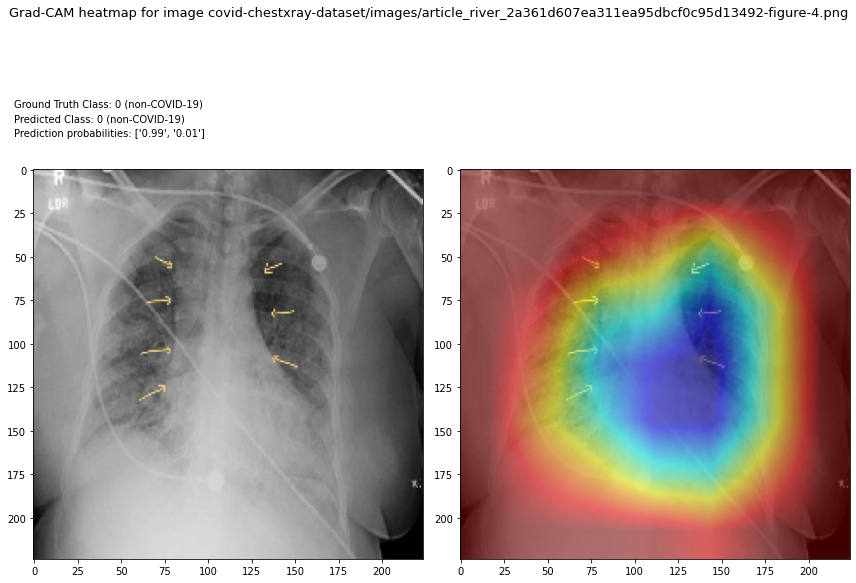

In [6]:
setup_dict = src.interpretability.gradcam.setup_gradcam('_class_weights')
heatmap = src.interpretability.gradcam.apply_gradcam(setup_dict, 22, hm_intensity=0.5, save_hm=True)

2_2_conv (Conv2D)    (None, 14, 14, 256)  589824      conv4_block2_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_block2_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_2_relu (Activation (None, 14, 14, 256)  0           conv4_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_out (Add)          (None, 14, 14, 1024) 0           conv4_block1_out[0][0]           
                                                                 conv4_block2_3_conv[0][0]        
_____________________

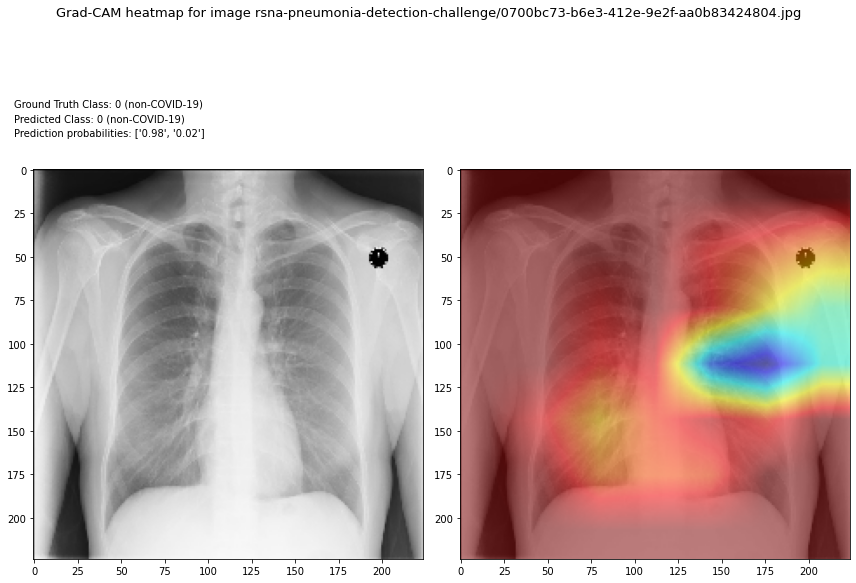

In [9]:
setup_dict = src.interpretability.gradcam.setup_gradcam('_random_oversample')
heatmap = src.interpretability.gradcam.apply_gradcam(setup_dict, 0, hm_intensity=0.5, save_hm=True)

2_2_conv (Conv2D)    (None, 14, 14, 256)  589824      conv4_block2_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_block2_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_2_relu (Activation (None, 14, 14, 256)  0           conv4_block2_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block2_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_out (Add)          (None, 14, 14, 1024) 0           conv4_block1_out[0][0]           
                                                                 conv4_block2_3_conv[0][0]        
_____________________

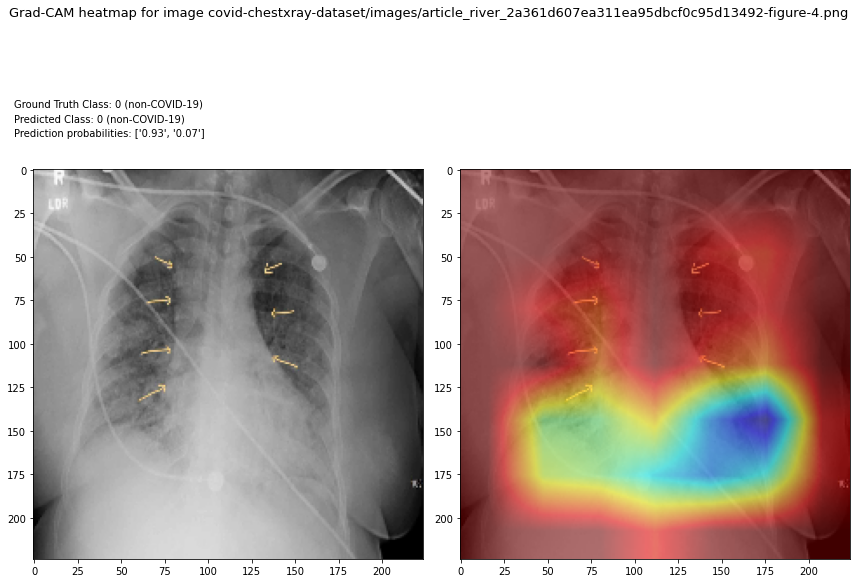

In [10]:
setup_dict = src.interpretability.gradcam.setup_gradcam('_random_oversample')
heatmap = src.interpretability.gradcam.apply_gradcam(setup_dict, 22, hm_intensity=0.5, save_hm=True)

# SHAP Tests #

Instructions for updating:
non-resource variables are not supported in the long term
Using TensorFlow backend.


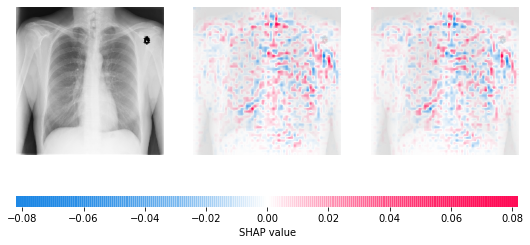

In [7]:
# use SHAP with resnet50v2 and class_weight
import numpy as np
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import get_session
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

tf.compat.v1.disable_v2_behavior()

import h5py
import shap
import keras.backend as K
import json

from tensorflow.keras.models import load_model
from keras.preprocessing import image
import src.custom.metrics

custom_objects={'F1Score':src.custom.metrics.F1Score()}

model = tf.keras.models.load_model('results/models/notebook_class_weight/class_weight_model20201116-145758.h5', custom_objects=custom_objects, compile=False)
from keras.preprocessing import image
img_width, img_height = 224, 224

img = image.load_img('data/rsna-pneumonia-detection-challenge/0700bc73-b6e3-412e-9e2f-aa0b83424804.jpg', target_size=(img_width, img_height))
to_explain  = image.img_to_array(img).reshape(1, img_width, img_height, 3)
X = to_explain.copy().reshape(1, img_width, img_height, 3)
   
# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return tf.compat.v1.keras.backend.get_session().run(model.layers[layer].input, feed_dict)

e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
class_names = { '0': ['negative', 'no-covid'], '1': ['positive', 'covid']  }

# plot the explanations
shap.image_plot(shap_values, to_explain)#, labels=class_names)

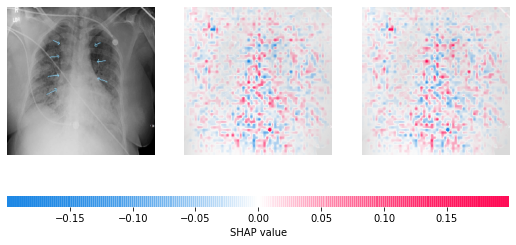

In [12]:
# use SHAP with ResNet50V2 and class_weight

model = tf.keras.models.load_model('results/models/notebook_class_weight/class_weight_model20201116-145758.h5', custom_objects=custom_objects, compile=False)
img = image.load_img('data/covid-chestxray-dataset/images/article_river_2a361d607ea311ea95dbcf0c95d13492-figure-4.png', target_size=(img_width, img_height))
to_explain  = image.img_to_array(img).reshape(1, img_width, img_height, 3)
X = to_explain.copy().reshape(1, img_width, img_height, 3)

e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# plot the explanations
shap.image_plot(shap_values, to_explain)


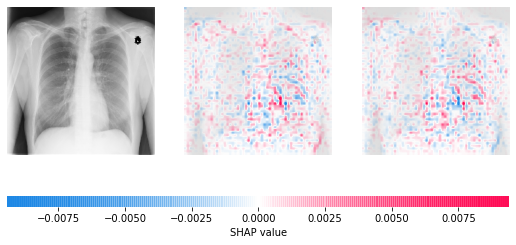

In [8]:
# use SHAP with resnet50v2 and random_oversample

model = tf.keras.models.load_model('results/models/notebook_random_oversample/model20201116-151632.h5', custom_objects=custom_objects, compile=False)
img = image.load_img('data/rsna-pneumonia-detection-challenge/0700bc73-b6e3-412e-9e2f-aa0b83424804.jpg', target_size=(img_width, img_height))
to_explain  = image.img_to_array(img).reshape(1, img_width, img_height, 3)
X = to_explain.copy().reshape(1, img_width, img_height, 3)

e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# plot the explanations
shap.image_plot(shap_values, to_explain)



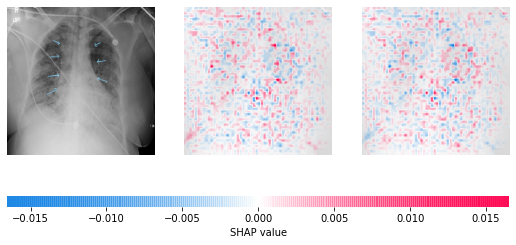

In [13]:
# use SHAP with ResNet50V2 and random_oversample
model = tf.keras.models.load_model('results/models/notebook_random_oversample/model20201116-151632.h5', custom_objects=custom_objects, compile=False)

img = image.load_img('data/covid-chestxray-dataset/images/article_river_2a361d607ea311ea95dbcf0c95d13492-figure-4.png', target_size=(img_width, img_height))
to_explain  = image.img_to_array(img).reshape(1, img_width, img_height, 3)
X = to_explain.copy().reshape(1, img_width, img_height, 3)

e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

shap.image_plot(shap_values, to_explain)#, labels=class_names)

## DISCUSSION

We began by training the classifier using both the class_weight as well as the random_oversample techniques, observing almost equivalent behavoir between the two. We note that the confusion matrix results differ greatly from our initial results using the custom dcnn_resnet model with class weights as shown here:

<img src="documents/submission_images/confusion_matrix_class_weights-first-run.png" width="600" height="600">

Compare those results with the same test except using the random_oversample:

<img src="documents/submission_images/confusion_matrix_random_oversample-first-run.png" width="600" height="600">

This test ran the full 200 epochs, and likely suffered from overfitting as is visible from the following tensorboard log, where the red line is the training accuracy and the blue line is the validation accuracy for class weights. Further, in the same figure the orange line and the gray line are the random_oversample training and validation accuracies, but the early stopping of the random_oversample run (~10 epochs) prevented overfitting. 

<img src="documents/submission_images/accuracy.PNG" width="800" height="800">

We did not observe this problem in our subsequent trials using ResNet50V2, since the training stopped early (again, on the order of 10 epochs)and, in combination with the earlier statement of seeking to maximize compatibility with the SHAP module, we are comfortable with our choice to use that classifier.

Moving to the explainability portion of our experiments, we began by running *LIME* and comparing the effect of using either class weight or random oversample.

The first two images show the results for correctly predicted results (ground truth and prediction of NON-COVID). We observe that the areas of significance in the prediction are mainly in the chest area, as is proposed by the authors premise.

<img src="documents/submission_images/lime_1.png">

<img src="documents/submission_images/lime_2.png">

In contrast, the second images display the results for incorrectly predicted diagnoses (ground truth NON-COVID but prediction of positive for COVID). Here we observe that in the first case, the areas of significance are largely outside of the chest cavity, which is not true in the second case, so LIME is apparently yielding inconsistent results. And the complete absence of red regions in the second image, which are indicators of areas of significance for in this case a positive diagnosis, is concerning.

<img src="documents/submission_images/lime_3.png">

<img src="documents/submission_images/lime_4.png">

Now looking at the *GRADCAM* results, the first two images are again for correctly predicted results, and we see that all of the predictions are in fact correct, but the use of either class weight (first two images) or random sample (second two images) does alter the areas of significance in the prediction.

<img src="documents/submission_images/gradcam_1.png">
<img src="documents/submission_images/gradcam_2.png">
<img src="documents/submission_images/gradcam_3.png">
<img src="documents/submission_images/gradcam_4.png">

Finally, the *SHAP* results are presented in the last four images. We should note here that we encountered many problems trying to implement SHAP, including initial configuration, problems with trying to change the model layer that the results are being generated from (we ended up only being able to use the default layer 7 configuration of the code as setup in the original repository), and we were unable to get the image labeling to work (we had to leave the field blank in the function call). Given these issues we think these results are of limited value.

What we can see is that the results appear to depend on the model, which given that we are looking at the impact of an early layer on the final output, may make sense. Our inability to see the effects of using higher layers is unfortunate. In any case, the results indicate the technique may be useful in helping to explain how a specific model makes predictions. Also, since both x-rays are from non-COVID patients, one would assume a fairly even distribution of indicators both classes, as appears to be the case. The first two images use ResNet50V2 trained with class weights, and the second two images use the same classifier trained with random oversample.

<img src="documents/submission_images/shap_1-cw.png">
<img src="documents/submission_images/shap_2-cw.png">
<img src="documents/submission_images/shap_3-ro.png">
<img src="documents/submission_images/shap_4-ro.png">

In summary, our tests indicated that LIME, GRADCAM, and SHAP appear to offer insight into how a model makes predictions, but at least in our evaluation the results for identifying COVID based solely on chest x-rays using these techniques is not compelling given their sensitivity to the model used for the analysis. That said, they may offer value in the actual selection of a model. 